# Assignment 2: OCR via Different Bayes Classifiers
## By: Amir Kamali

In [184]:
import pandas as pd
import numpy as np
import seaborn as sn

import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

from scipy.stats import multivariate_normal as mvn

%matplotlib inline


'/Users/amir'

The functions that is used in this noteook:

In [131]:
def show_me(X):
    plt.imshow(X.reshape(28,28))
    
def normalize(X):
    return X.astype(float) / 255

class GenBayes():
    
    def fit(self, X, y, DistStr, epsilon = 1e-3):
        N, D = X.shape
        
        self.likelihoods = dict()
        self.priors = dict()
        
        # sometimes y is float or boolean, etc. So we make sure they are converted into ints
        self.K = set(y.astype(int))


        if DistStr == "Naive":
            for k in self.K:
                X_k = X[y==k, :]
                self.likelihoods[k] = {"mean":X_k.mean(axis=0), "cov":X_k.var(axis=0) + epsilon}
                self.priors[k] = len(X_k)/N
        
        if DistStr == "Gauss":
            for k in self.K:
                X_k = X[y == k,:]
                N_k, D = X_k.shape
                mu_k=X_k.mean(axis=0)
                
                self.likelihoods[k] = {"mean":X_k.mean(axis=0), "cov":(1/(N_k-1))*np.matmul((X_k-mu_k).T,X_k-mu_k)+ epsilon*np.identity(D)}
                self.priors[k] = len(X_k)/N
        
        if DistStr == "Multinomial":
            pass
        
        if DistStr == "Bernoulli":
            for k in self.K:
                X_k = X[y==k, :]
                N_k, D = X_k.shape
                p = (sum(X_k)+1) / (N_k + 2)
                # p is a list if X is a matrix.
                self.likelihoods[k] = {'mean' : p, 'cov' : p * (1-p) + epsilon}
                self.priors[k] = N_k/N
            
            
    def predict(self, X, DistStr):
        N, D = X.shape
        P_hat = np.zeros((N,len(self.K)))

        if DistStr == "Naive":
            for k,l in self.likelihoods.items():
                P_hat[:,k] = mvn.logpdf(X, l["mean"], l["cov"])+np.log(self.priors[k])
            return P_hat.argmax(axis = 1)

        if DistStr == "Gauss":
            for k, l in self.likelihoods.items():
                P_hat[:,k] = mvn.logpdf(X, l["mean"], l["cov"]) + np.log(self.priors[k])
            return P_hat.argmax(axis = 1)
        
        if DistStr == "Multinomial":
            pass
        
        if DistStr == "Bernoulli":
            for k, l in self.likelihoods.items():
                # matmul is matrix multiplication
                # Using bernoulli function/formula. Trick is to get the matrices/vectors to go from m*n to a 1*1 number for each k value.
                P_hat[:,k] = np.log(self.priors[k]) + np.matmul(X, np.log(l["mean"])) + np.matmul((1-X), np.log(l["cov"]))
            return P_hat.argmax(axis = 1)
        
def accuracy(y, y_hat):
    return np.mean(y == y_hat)

def predict_gaussian(gb1, gb2, gb3, X_test, y_test):
    result = []
    y_hat_test_1 = gb1.predict(X_test, 'Gauss')
    print('Accuracy of the first classifier=', accuracy(y_test, y_hat_test_1))

    y_hat_test_2 = gb2.predict(X_test, 'Gauss')
    print('Accuracy of the second classifier=', accuracy(y_test, y_hat_test_1))

    y_hat_test_3 = gb3.predict(X_test, 'Gauss')
    print('Accuracy of the third classifier=', accuracy(y_test, y_hat_test_1))

    allAgreedCount = 0
    twoAgreedCount = 0
    for i in range(len(y_hat_test_1)):
        if y_hat_test_1[i] == y_hat_test_2[i] and y_hat_test_1[i] == y_hat_test_3[i]:
            allAgreedCount += 1

        if y_hat_test_1[i] == y_hat_test_2[i] or y_hat_test_1[i] == y_hat_test_3[i]:
            twoAgreedCount += 1
            result.append(y_hat_test_1[i])
        elif y_hat_test_2[i] == y_hat_test_3[i]:
            twoAgreedCount += 1
            result.append(y_hat_test_2[i])
        else:
            # No two out of the three results are the same. I just pick y_hat_test_1 as the result.
            result.append(y_hat_test_2[i])
    print('All classifiers agreed on', allAgreedCount, 'samples')
    print('At least two classifiers agreed on', twoAgreedCount, 'samples')
    return result


The main body of the code:

In [132]:
train_data = pd.read_csv("Documents/Amir/SampleFiles/MNIST_train.csv", header=0)
X_train = train_data.to_numpy()
print(X_train.shape)
y_train = X_train[:, 2]
X_train = X_train[:,3:]
train_data.describe()

(60000, 787)


,Unnamed: 0,index,labels,0,1,2,3,4,5,6,...,774,775,776,777,778,779,780,781,782,783
count,60000.000000,60000.000000,60000.000000,60000.0,60000.0,60000.0,60000.0,60000.0,60000.0,60000.0,...,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.0000,60000.0,60000.0,60000.0,60000.0
mean,29999.500000,29999.500000,4.453933,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.200433,0.088867,0.045633,0.019283,0.015117,0.0020,0.0,0.0,0.0,0.0
std,17320.652413,17320.652413,2.889270,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,6.042472,3.956189,2.839845,1.686770,1.678283,0.3466,0.0,0.0,0.0,0.0
min,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.0000,0.0,0.0,0.0,0.0
25%,14999.750000,14999.750000,2.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.0000,0.0,0.0,0.0,0.0
50%,29999.500000,29999.500000,4.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.0000,0.0,0.0,0.0,0.0
75%,44999.250000,44999.250000,7.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.0000,0.0,0.0,0.0,0.0
max,59999.000000,59999.000000,9.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,254.000000,254.000000,253.000000,253.000000,254.000000,62.0000,0.0,0.0,0.0,0.0


In [133]:
test_data = pd.read_csv("Documents/Amir/SampleFiles/MNIST_test.csv", header=0)
X_test = test_data.to_numpy()
print(X_test.shape)
y_test = X_test[:, 2]
X_test = X_test[:,3:]
test_data.describe()

(10000, 787)


,Unnamed: 0,index,labels,0,1,2,3,4,5,6,...,774,775,776,777,778,779,780,781,782,783
count,10000.00000,10000.00000,10000.000000,10000.0,10000.0,10000.0,10000.0,10000.0,10000.0,10000.0,...,10000.000000,10000.000000,10000.000000,10000.0000,10000.0,10000.0,10000.0,10000.0,10000.0,10000.0
mean,4999.50000,4999.50000,4.443400,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.179300,0.163600,0.052600,0.0006,0.0,0.0,0.0,0.0,0.0,0.0
std,2886.89568,2886.89568,2.895865,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,5.674149,5.736072,2.420004,0.0600,0.0,0.0,0.0,0.0,0.0,0.0
min,0.00000,0.00000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.0000,0.0,0.0,0.0,0.0,0.0,0.0
25%,2499.75000,2499.75000,2.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.0000,0.0,0.0,0.0,0.0,0.0,0.0
50%,4999.50000,4999.50000,4.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.0000,0.0,0.0,0.0,0.0,0.0,0.0
75%,7499.25000,7499.25000,7.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.0000,0.0,0.0,0.0,0.0,0.0,0.0
max,9999.00000,9999.00000,9.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,253.000000,253.000000,156.000000,6.0000,0.0,0.0,0.0,0.0,0.0,0.0


Finding the accuracy of the three classifiers before normalizing data.

In [134]:
gb = GenBayes()

In [135]:
gb.fit(X_train,y_train, 'Naive', epsilon = 0.016)
y_hat_test = gb.predict(X_test, 'Naive')
print(f'Naive Accuracy : {accuracy(y_test, y_hat_test)*10000/100:.2f}%')

Naive Accuracy : 61.73%


In [136]:
gb.fit(X_train,y_train, 'Gauss', epsilon = 0.016)
y_hat_test = gb.predict(X_test, 'Gauss')
print(f'Gauss Accuracy : {accuracy(y_test, y_hat_test)*10000/100:.2f}%')

Gauss Accuracy : 78.75%


In [137]:
gb.fit(X_train,y_train, 'Bernoulli', epsilon = 160)
y_hat_test = gb.predict(X_test, 'Bernoulli')
print(f'Bernoulli Accuracy : {accuracy(y_test, y_hat_test)*10000/100:.2f}%')

<ipython-input-131-7f9170a0b508>:68: RuntimeWarning: invalid value encountered in log
  P_hat[:,k] = np.log(self.priors[k]) + np.matmul(X, np.log(l["mean"])) + np.matmul((1-X), np.log(l["cov"]))


Bernoulli Accuracy : 9.80%


Text(0, 0.5, 'accuracy (Percent)')

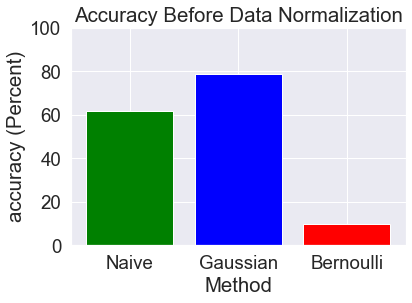

In [181]:
best_accuracies = [61.73, 78.75, 9.80]
models = ["Naive", "Gaussian", "Bernoulli"]
plt.figure()
plt.ylim(0, 100)
plt.bar(models, best_accuracies, color=['green', 'blue', 'red'])
plt.title("Accuracy Before Data Normalization")
plt.xlabel("Method")
plt.ylabel("accuracy (Percent)")

Normalizing the features between 0 to 1.

In [139]:
X_train = normalize(X_train)
X_test = normalize(X_test)


Finding the mean value for each digit in training data.

In [140]:
digits_pixel_mean = []
digit_max_variation = []
for digit in range(10):
    X_digit = X_train[y_train==digit, :]
    print('Size of X_', digit, '=', X_digit.shape)
    pixel_mean = np.mean(X_digit, axis=0)
    digits_pixel_mean.append(pixel_mean)
    pixel_variation = [0]* len(pixel_mean)
    max_index = -1
    max_variation_sum = 0
    for i in range(len(X_digit)):
        image = X_digit[i]
        pixel_variation = (image - pixel_mean)**2
        variation_sum = sum(pixel_variation)
        if max_variation_sum < variation_sum:
            max_index = i
            max_variation_sum = variation_sum
    digit_max_variation.append([max_index, X_digit[max_index,:]])
    print('pixel_variation max= ',max(pixel_variation))

Size of X_ 0 = (5923, 784)
pixel_variation max=  0.960438022973519
Size of X_ 1 = (6742, 784)
pixel_variation max=  0.7930933242916953
Size of X_ 2 = (5958, 784)
pixel_variation max=  0.9187822293865937
Size of X_ 3 = (6131, 784)
pixel_variation max=  0.6710578552152299
Size of X_ 4 = (5842, 784)
pixel_variation max=  0.6949379166971438
Size of X_ 5 = (5421, 784)
pixel_variation max=  0.8133871071935683
Size of X_ 6 = (5918, 784)
pixel_variation max=  0.8113985317024253
Size of X_ 7 = (6265, 784)
pixel_variation max=  0.9716530143850078
Size of X_ 8 = (5851, 784)
pixel_variation max=  0.7422061463438345
Size of X_ 9 = (5949, 784)
pixel_variation max=  0.8157084589901266


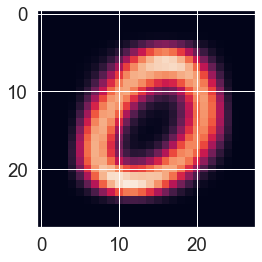

In [141]:
show_me(digits_pixel_mean[0])

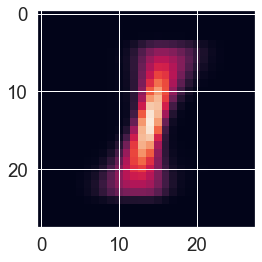

In [142]:
show_me(digits_pixel_mean[1])

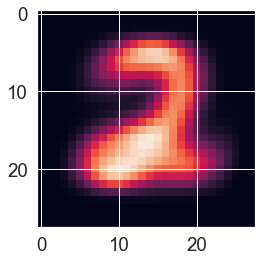

In [143]:
show_me(digits_pixel_mean[2])

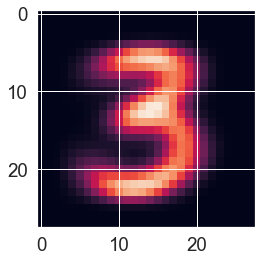

In [144]:
show_me(digits_pixel_mean[3])

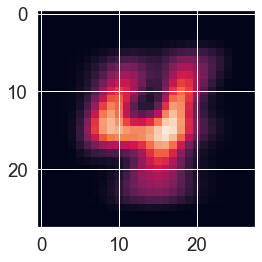

In [145]:
show_me(digits_pixel_mean[4])

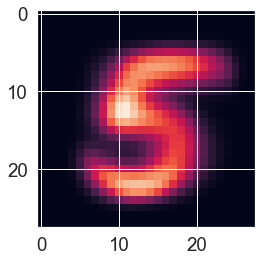

In [146]:
show_me(digits_pixel_mean[5])

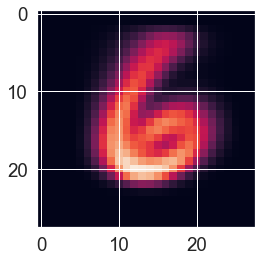

In [147]:
show_me(digits_pixel_mean[6])

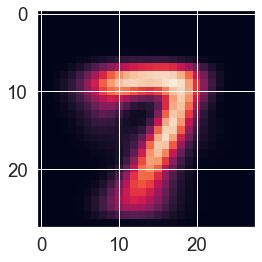

In [148]:
show_me(digits_pixel_mean[7])

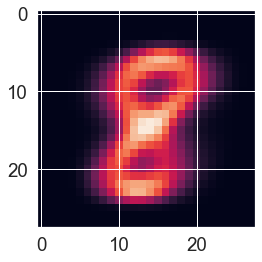

In [149]:
show_me(digits_pixel_mean[8])

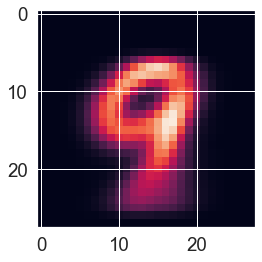

In [150]:
show_me(digits_pixel_mean[9])

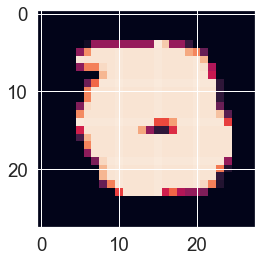

In [151]:
show_me(digit_max_variation[0][1])

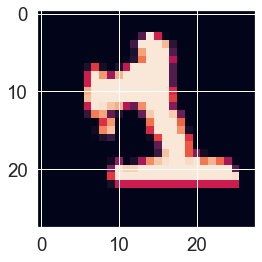

In [152]:
show_me(digit_max_variation[1][1])

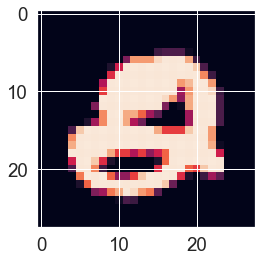

In [153]:
show_me(digit_max_variation[2][1])

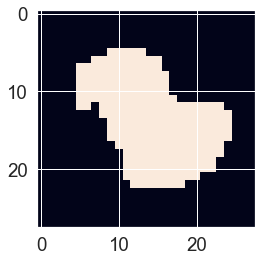

In [154]:
show_me(digit_max_variation[3][1])

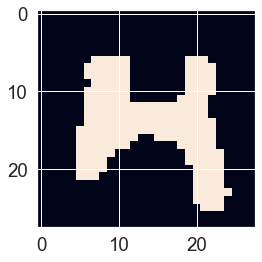

In [155]:
show_me(digit_max_variation[4][1])

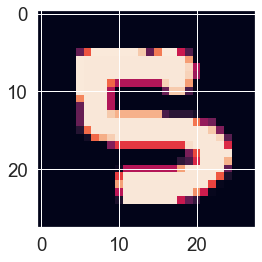

In [156]:
show_me(digit_max_variation[5][1])

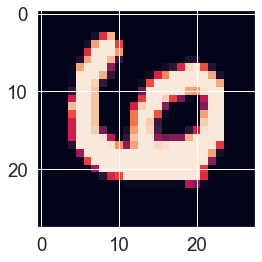

In [157]:
show_me(digit_max_variation[6][1])

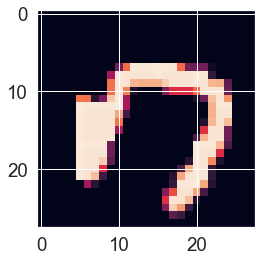

In [158]:
show_me(digit_max_variation[7][1])

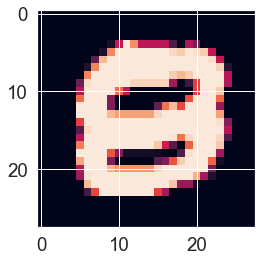

In [159]:
show_me(digit_max_variation[8][1])

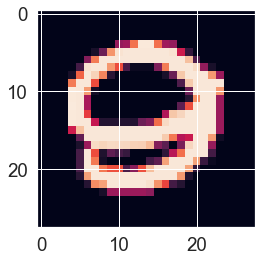

In [160]:
show_me(digit_max_variation[9][1])

Tuning the epsilon for best performance of the three classifiers.

In [161]:
naive_train_epsilons=[]
naive_train_accuracies=[]
naive_test_epsilons=[]
naive_test_accuracies=[]

for eps in range(5, 35):
    gb.fit(X_train,y_train, 'Naive', epsilon = eps*1e-3)
    y_hat_test = gb.predict(X_test, 'Naive')
    acc = accuracy(y_test, y_hat_test)
    naive_test_epsilons.append(eps)
    naive_test_accuracies.append(int(acc * 100000) / 1000)

print(naive_test_epsilons)
print(naive_test_accuracies)

[5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34]
[80.51, 80.62, 80.84, 81.07, 81.18, 81.41, 81.46, 81.43, 81.45, 81.46, 81.46, 81.54, 81.47, 81.39, 81.44, 81.41, 81.39, 81.38, 81.3, 81.31, 81.31, 81.33, 81.34, 81.24, 81.21, 81.18, 81.12, 81.08, 81.12, 81.08]


Best epsilon for Naive is 0.016 and its accuracy is 81.54%

In [162]:
gauss_train_epsilons=[]
gauss_train_accuracies=[]
gauss_test_epsilons=[]
gauss_test_accuracies=[]

for eps in range(25, 60):
    gb.fit(X_train,y_train, 'Gauss', epsilon = eps*1e-3)
    y_hat_test = gb.predict(X_test, 'Gauss')
    acc = accuracy(y_test, y_hat_test)
    gauss_test_epsilons.append(eps)
    gauss_test_accuracies.append(int(acc * 100000) / 1000)

print(gauss_test_epsilons)
print(gauss_test_accuracies)

[25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59]
[95.56, 95.59, 95.59, 95.6, 95.59, 95.64, 95.62, 95.65, 95.64, 95.64, 95.64, 95.64, 95.64, 95.66, 95.66, 95.7, 95.7, 95.7, 95.71, 95.71, 95.7, 95.65, 95.65, 95.64, 95.64, 95.63, 95.65, 95.66, 95.65, 95.62, 95.62, 95.65, 95.65, 95.65, 95.69]


Best epsilon for Gauss is 0.0435 and its accuracy is 95.71%

In [163]:
bernoulli_train_epsilons=[]
bernoulli_train_accuracies=[]
bernoulli_test_epsilons=[]
bernoulli_test_accuracies=[]

for eps in range(159000, 170000, 100):
    gb.fit(X_train,y_train, 'Bernoulli', epsilon = eps*1e-3)
    y_hat_test = gb.predict(X_test, 'Bernoulli')
    acc = accuracy(y_test, y_hat_test)
    bernoulli_test_epsilons.append(eps)
    bernoulli_test_accuracies.append(int(acc * 100000) / 1000)

print(bernoulli_test_epsilons)
print(bernoulli_test_accuracies)

[159000, 159100, 159200, 159300, 159400, 159500, 159600, 159700, 159800, 159900, 160000, 160100, 160200, 160300, 160400, 160500, 160600, 160700, 160800, 160900, 161000, 161100, 161200, 161300, 161400, 161500, 161600, 161700, 161800, 161900, 162000, 162100, 162200, 162300, 162400, 162500, 162600, 162700, 162800, 162900, 163000, 163100, 163200, 163300, 163400, 163500, 163600, 163700, 163800, 163900, 164000, 164100, 164200, 164300, 164400, 164500, 164600, 164700, 164800, 164900, 165000, 165100, 165200, 165300, 165400, 165500, 165600, 165700, 165800, 165900, 166000, 166100, 166200, 166300, 166400, 166500, 166600, 166700, 166800, 166900, 167000, 167100, 167200, 167300, 167400, 167500, 167600, 167700, 167800, 167900, 168000, 168100, 168200, 168300, 168400, 168500, 168600, 168700, 168800, 168900, 169000, 169100, 169200, 169300, 169400, 169500, 169600, 169700, 169800, 169900]
[68.99, 68.99, 68.99, 68.99, 68.99, 68.99, 68.99, 68.99, 68.99, 68.99, 69.0, 69.0, 69.0, 69.0, 69.0, 69.0, 69.0, 69.0, 

Best epsilon for Bernoulli is 160 and its accuracy is 69.0%

Pltting The three scater plots of epsilon tuning.

Text(0, 0.5, 'accuracy (Percent)')

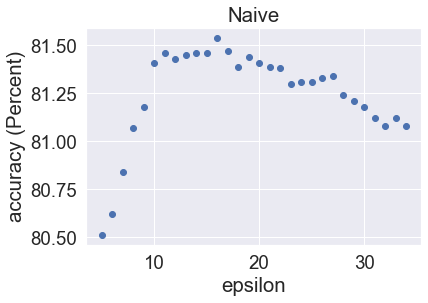

In [176]:
plt.figure()
plt.scatter(naive_test_epsilons, naive_test_accuracies)
plt.title("Naive")
plt.xlabel("epsilon")
plt.ylabel("accuracy (Percent)")

Text(0, 0.5, 'accuracy (Percent)')

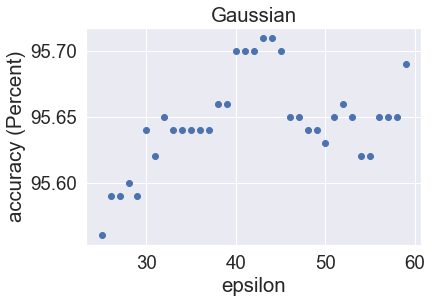

In [174]:
plt.figure()
plt.scatter(gauss_test_epsilons, gauss_test_accuracies)
plt.title("Gaussian")
plt.xlabel("epsilon")
plt.ylabel("accuracy (Percent)")

Text(0, 0.5, 'accuracy (Percent)')

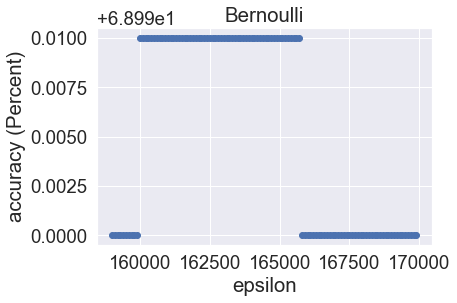

In [177]:
plt.figure()
plt.scatter(bernoulli_test_epsilons, bernoulli_test_accuracies)
plt.title("Bernoulli")
plt.xlabel("epsilon")
plt.ylabel("accuracy (Percent)")

Comparing all three classifiers after data normalization.

Text(0, 0.5, 'accuracy (Percent)')

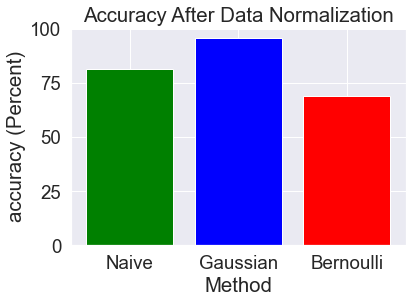

In [180]:
best_accuracies = [81.54, 95.71, 69.0]
models = ["Naive", "Gaussian", "Bernoulli"]
plt.figure()
plt.bar(models, best_accuracies, color=['green', 'blue', 'red'])
plt.title("Accuracy After Data Normalization")
plt.xlabel("Method")
plt.ylabel("accuracy (Percent)")

Gaussian classifier showed the best test results. It is used as the candidate for final tests. In final step. I split the training data into three equal sets, train three independent Gaussian classifier with those data and test them with the test data simultaneously. Then I poll between the three classifers. I measure the result with indivitual result of the classifiers.

Now we try to improve the performance of the Gaussian classifier.

In [168]:
X_train_1 = X_train[:20000,:]
y_train_1 = y_train[:20000]
X_train_2 = X_train[20000:40000,:]
y_train_2 = y_train[20000:40000]
X_train_3 = X_train[40000:,:]
y_train_3 = y_train[40000:]

In [169]:
accuracy_list=[]
gb1 = GenBayes()
gb1.fit(X_train_1,y_train_1, 'Gauss', epsilon = 0.0435)

gb2 = GenBayes()
gb2.fit(X_train_2,y_train_2, 'Gauss', epsilon = 0.0435)

gb3 = GenBayes()
gb3.fit(X_train_3,y_train_3, 'Gauss', epsilon = 0.0435)

y_hat_test = predict_gaussian(gb1, gb2, gb3, X_test, y_test)
print('Accuracy of the polled data=', accuracy(y_test, y_hat_test))

Accuracy of the first classifier= 0.9563
Accuracy of the second classifier= 0.9563
Accuracy of the third classifier= 0.9563
All classifiers agreed on 9784 samples
At least two classifiers agreed on 9992 samples
Accuracy of the polled data= 0.957


The individual accuracies slightly dropped to 95.63%. The polling increased it to 95.72%. We need to try another idea. I add some randomly selected samples to each of the individual training sets.

In [170]:
data_1 = train_data[train_data['index'] > 20000].sample(frac=0.5)
X_train_random_1 = data_1.to_numpy()
y_train_random_1 = X_train_random_1[:, 2]
X_train_random_1 = X_train_random_1[:,3:]
new_X_train_1 = np.vstack((X_train_1, X_train_random_1))
new_y_train_1 = np.concatenate((y_train_1, y_train_random_1), axis=0)


data_2 = pd.concat([train_data[train_data['index'] < 20000], train_data[train_data['index'] > 40000]], ignore_index=True).sample(frac=0.5)
X_train_random_2 = data_2.to_numpy()
y_train_random_2 = X_train_random_2[:, 2]
X_train_random_2 = X_train_random_2[:,3:]
new_X_train_2 = np.vstack((X_train_2, X_train_random_2))
new_y_train_2 = np.concatenate((y_train_2, y_train_random_2), axis=0)


data_3 = train_data[train_data['index'] < 40000].sample(frac=0.5)
X_train_random_3 = data_3.to_numpy()
y_train_random_3 = X_train_random_3[:, 2]
X_train_random_3 = X_train_random_3[:,3:]
new_X_train_3 = np.vstack((X_train_3, X_train_random_3))
new_y_train_3 = np.concatenate((y_train_3, y_train_random_3), axis=0)


accuracy_list=[]
gb4 = GenBayes()
gb4.fit(new_X_train_1,new_y_train_1, 'Gauss', epsilon = 0.0435)

gb5 = GenBayes()
gb5.fit(new_X_train_2,new_y_train_2, 'Gauss', epsilon = 0.0435)

gb6 = GenBayes()
gb6.fit(new_X_train_3,new_y_train_3, 'Gauss', epsilon = 0.0435)

new_y_hat_test = predict_gaussian(gb4, gb5, gb6, X_test, y_test)
print('Accuracy of the polled data=', accuracy(y_test, new_y_hat_test))

Accuracy of the first classifier= 0.1135
Accuracy of the second classifier= 0.1135
Accuracy of the third classifier= 0.1135
All classifiers agreed on 10000 samples
At least two classifiers agreed on 10000 samples
Accuracy of the polled data= 0.1135


In [171]:
X_train_1_3 = X_train[:40000,:]
y_train_1_3 = y_train[:40000]
X_train_2_3 = X_train[10000:50000,:]
y_train_2_3 = y_train[10000:50000]
X_train_3_3 = X_train[20000:,:]
y_train_3_3 = y_train[20000:]


accuracy_list=[]
gb7 = GenBayes()
gb7.fit(X_train_1_3,y_train_1_3, 'Gauss', epsilon = 0.0435)

gb8 = GenBayes()
gb8.fit(X_train_2_3,y_train_2_3, 'Gauss', epsilon = 0.0435)

gb9 = GenBayes()
gb9.fit(X_train_3_3,y_train_3_3, 'Gauss', epsilon = 0.0435)

y_hat_test_3 = predict_gaussian(gb7, gb8, gb9, X_test, y_test)
print('Accuracy of the polled data=', accuracy(y_test, y_hat_test_3))

Accuracy of the first classifier= 0.9571
Accuracy of the second classifier= 0.9571
Accuracy of the third classifier= 0.9571
All classifiers agreed on 9911 samples
At least two classifiers agreed on 10000 samples
Accuracy of the polled data= 0.9565


In the last step, I find the confusion matrix based on the best of the testing results I had so far.

In [172]:
reds = plt.get_cmap('Reds', 1200)
newcolors = reds(np.linspace(0, 1, 1200))

zero_values = np.array([256/256, 256/256, 256/256, 1])
newcolors[:1, :] = zero_values

below_five_values = np.array([256/256, 240/256, 240/256, 1])
newcolors[1:5, :] = below_five_values

below_ten_values = np.array([256/256, 225/256, 225/256, 1])
newcolors[5:10, :] = below_ten_values

below_twnety_values = np.array([256/256, 210/256, 210/256, 1])
newcolors[10:20, :] = below_twnety_values

below_thirty_values = np.array([256/256, 195/256, 195/256, 1])
newcolors[20:30, :] = below_thirty_values

below_forty_values = np.array([256/256, 180/256, 180/256, 1])
newcolors[30:40, :] = below_forty_values

other_values = np.array([256/256, 165/256, 165/256, 1])
newcolors[40:100, :] = other_values

diagonal_values = np.array([256/256, 256/256, 256/256, 1])
newcolors[100:1200, :] = diagonal_values

newcmp =  ListedColormap(newcolors)

The accuracy of Gaussian Bayes classifier is 95.72.
y_test.shape= (10000,) , y_hat_test.shape= (10000,)


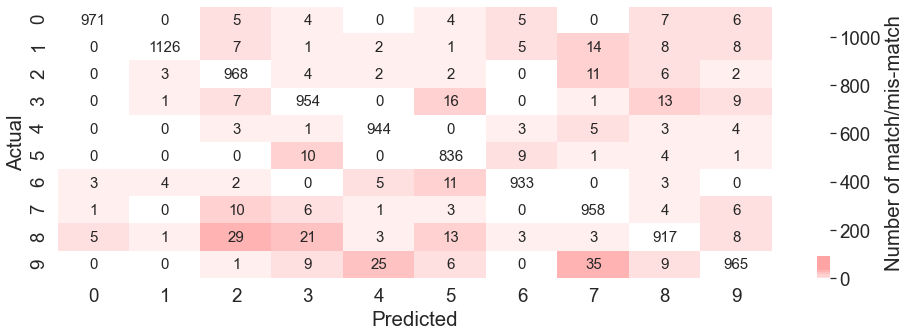

In [173]:
my_gb = GenBayes()
my_gb.fit(X_train, y_train, 'Gauss', epsilon = 0.0435)
y_hat_test = my_gb.predict(X_test, 'Gauss')
print(f'The accuracy of Gaussian Bayes classifier is {(accuracy(y_test, y_hat_test)*100):0.2f}.')
print('y_test.shape=', y_test.shape, ', y_hat_test.shape=', y_hat_test.shape)

confusion_matrix = pd.crosstab(y_hat_test, y_test, rownames=['Actual'], colnames=['Predicted'])

sn.set(font_scale=1.7)
plt.figure(figsize=(16,5))
heatmap = sn.heatmap(confusion_matrix, cmap=newcmp, fmt=".0f", annot=True, annot_kws={"size": 15},
                    cbar_kws={'label': 'Number of match/mis-match'})
plt.show()